In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K

2024-06-13 19:57:33.418558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 19:57:33.558515: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 19:57:33.562208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-13 19:57:33.562224: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [3]:
VOCAB_SIZE = 10000
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [4]:
df = pd.read_csv("trainb.csv", delimiter="|")
dataset = tf.data.Dataset.from_tensor_slices((df["text"],df["class"]))

testDf = pd.read_csv("testb.csv", delimiter="|")
test = tf.data.Dataset.from_tensor_slices((testDf["text"],testDf["class"]))


2024-06-13 19:57:38.292273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /WAVE/archive/users/achoudhury2/.local/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-13 19:57:38.292307: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-13 19:57:38.292324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mem01.wave.scu.edu): /proc/driver/nvidia/version does not exist
2024-06-13 19:57:38.292665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations,

In [5]:
train_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# encoder.adapt(df['text'])  # train_dataset.map(lambda text, label: text)
encoder.adapt(train_dataset.map(lambda text, label: text))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'to', 'a', 'of', 'is', 'in', 'and', 'i', 'for',
       'this', 'that', 'you', 'on', 'it', 'be', 'with', 'are', 'what',
       'have', 'not', 'my', 'so', 'at', 'they', 'just', 'was', 'but',
       'like', 'its', 'as', 'if', 'all', 'he', 'from', 'people', 'how',
       'we', 'your', 'will', 'about', 'do', 'an', 'no', 'by', 'can',
       'one', 'has', 'would', 'dont', 'get', 'his', 'who', 'out', 'me',
       'when', 'because', 'why', 'more', 'up', 'im', 'or', 'their', 'new',
       'now', 'only', 'good', 'should', 'think', 'game', 'there', 'trump',
       'than', 'time', 'after', 'know', 'them', 'well', 'some', 'see',
       'us', 'thats', 'make', 'him', 'really', 'right', 'cant', 'man',
       'were', 'being', 'over', 'first', 'her', 'got', 'been', 'did',
       'too', 'going', 'could'], dtype='<U17')

In [8]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy', 
                        f1_m,
                        recall_m,
                        precision_m,
                        # tf.keras.metrics.Precision(),
                        # tf.keras.metrics.Recall(),
                        # 'F1Score'
                      ]
             )

In [10]:
# for example, label in train_dataset.take(1):
#     print('texts: ', example.numpy()[:3])
#     encoded_example = encoder(example)[:3].numpy()
#     for n in range(3):
#         print("Original: ", example[n].numpy())
#         print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
#         print()
#     print('labels: ', label.numpy()[:3])

In [11]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
4017/4017 [==============================] - 176s 42ms/step - loss: 0.6523 - accuracy: 0.5790 - f1_m: 0.3445 - recall_m: 0.2464 - precision_m: 0.6263 - val_loss: 0.6386 - val_accuracy: 0.6073 - val_f1_m: 0.4623 - val_recall_m: 0.3427 - val_precision_m: 0.7310
Epoch 2/10
4017/4017 [==============================] - 169s 42ms/step - loss: 0.6187 - accuracy: 0.6315 - f1_m: 0.5092 - recall_m: 0.3917 - precision_m: 0.7537 - val_loss: 0.6373 - val_accuracy: 0.6250 - val_f1_m: 0.5479 - val_recall_m: 0.4594 - val_precision_m: 0.6885
Epoch 3/10
4017/4017 [==============================] - 170s 42ms/step - loss: 0.6072 - accuracy: 0.6460 - f1_m: 0.5428 - recall_m: 0.4306 - precision_m: 0.7569 - val_loss: 0.6352 - val_accuracy: 0.6182 - val_f1_m: 0.5259 - val_recall_m: 0.4281 - val_precision_m: 0.6912
Epoch 4/10
4017/4017 [==============================] - 170s 42ms/step - loss: 0.6001 - accuracy: 0.6544 - f1_m: 0.5619 - recall_m: 0.4530 - precision_m: 0.7590 - val_loss: 0.6343 - val_a

1011/1011 [==============================] - 12s 12ms/step - loss: 0.6626 - accuracy: 0.6294 - f1_m: 0.5528 - recall_m: 0.4641 - precision_m: 0.6959
dict_keys(['loss', 'accuracy', 'f1_m', 'recall_m', 'precision_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_recall_m', 'val_precision_m'])
Test Loss: 0.6625986695289612
Test Accuracy: 0.6293879151344299
Test F1: 0.5528166890144348
Test Recall: 0.46410638093948364
Test Precision: 0.6959076523780823


(0.0, 0.6770294487476349)

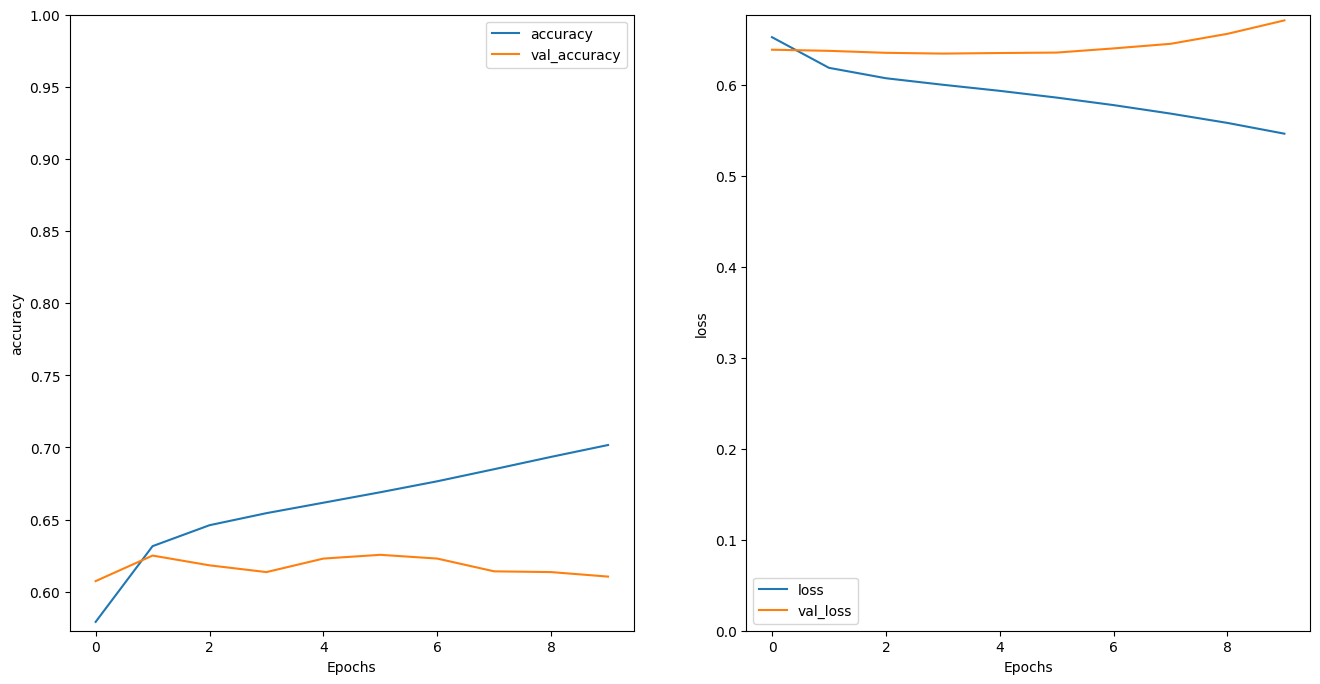

In [12]:
test_loss, test_acc, test_f1, test_recall, test_p = model.evaluate(test_dataset)

print(history.history.keys())

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test F1:', test_f1)
print('Test Recall:', test_recall)
print('Test Precision:', test_p)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [13]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I completely love this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[-0.6656969]]


In [14]:
a = "I really appreciate the effort you put into this project. Great job!"
b = "Thank you for your prompt response. It was very helpful."
c = "Oh, fantastic! Another meeting that could've been an email. My day is complete."
d = "Wow, your internet connection is so fast! I almost didn't have time to make a cup of coffee while waiting."
predictions = model.predict(np.array([a,b,c,d]))
print(predictions)

1/1 [==============================] - 0s 21ms/step
[[0.7676179 ]
 [1.5547687 ]
 [0.39530405]
 [0.16372606]]
